In [31]:
import os

In [32]:
print(os.getcwd())

/tf/home/sergio/Tesis/COCODataset/pedestrian_dataset_val


In [33]:
root_path = "/tf/home/sergio/Tesis"

In [34]:
import sys
sys.path.append(root_path+"/TinyYOLOv3-Pedestrian-Detection")
from YOLOblocks import TinyYOLOv3,BasicBlock,PredictionLayer#,YOLOLossBasicBlock

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf

from skimage.io import imread,imshow
from skimage.transform import resize
import time
import os

from pycocotools.coco import COCO

In [35]:
def get_iou_matrix_tf(box_arr1, box_arr2):
    #print(box_arr1)
    #print(box_arr2)
    x11, y11, x12, y12 = tf.split(box_arr1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(box_arr2, 4, axis=1)
    xA = tf.maximum(x11, tf.transpose(x21))
    #print(xA)
    yA = tf.maximum(y11, tf.transpose(y21))
    #print(yA)
    xB = tf.minimum(x12, tf.transpose(x22))
    #print(xB)
    yB = tf.minimum(y12, tf.transpose(y22))
    #print(yB)
    interArea = tf.maximum((xB - xA + 1e-9), 0) * tf.maximum((yB - yA + 1e-9), 0)
    #print("interseccion",interArea)
    boxAArea = (x12 - x11 + 1e-9) * (y12 - y11 + 1e-9)
    #print("area gt",boxAArea)
    boxBArea = (x22 - x21 + 1e-9) * (y22 - y21 + 1e-9)
    #print("area pre",boxBArea)
    iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)
    #print(iou)
    return tf.cast(iou>=0.5,dtype=tf.int32),iou

In [36]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end

    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [37]:
os.chdir(root_path+"/COCODataset/coco_csvs")
annotations_val_set = pd.read_csv("COCO_annotations_val.csv")
annotations_val_set.drop("Unnamed: 0",axis=1)

,file_name,xmin,ymin,xmax,ymax
0,000000532481.jpg,0.391906,0.394977,0.501453,0.547277
1,000000532481.jpg,0.446172,0.869859,0.465031,0.914953
2,000000458755.jpg,0.107859,0.078646,0.901687,0.986521
3,000000458755.jpg,0.885938,0.002646,1.000000,0.183604
4,000000458755.jpg,0.921906,0.191021,0.999437,0.393250
...,...,...,...,...,...
10999,000000098287.jpg,0.870193,0.408687,0.882000,0.440844
11000,000000098287.jpg,0.419277,0.389062,0.455422,0.418750
11001,000000417779.jpg,0.736297,0.178083,0.765656,0.267104
11002,000000024567.jpg,0.000000,0.000000,0.876958,0.745188


In [38]:
metadata_val_set = pd.read_csv("COCO_metadata_val.csv",index_col=0)

In [39]:
metadata_val_set

,width,height
000000532481.jpg,640,426
000000458755.jpg,640,480
000000385029.jpg,640,480
000000311303.jpg,640,427
000000393226.jpg,640,480
...,...,...
000000229358.jpg,640,423
000000098287.jpg,415,640
000000417779.jpg,640,480
000000024567.jpg,480,640


In [40]:
os.chdir(root_path+"/COCODataset/pedestrian_dataset_val")
validation_images_names = os.listdir()
print(len(validation_images_names))

2693


In [41]:
detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","TP","FP","cum TP","cum FP","precision","recall"])

In [42]:
#anchors =[[0.026,0.062],[0.067,0.183],[0.128,0.323],[0.343,0.650]]
anchors =[[0.02078,0.049],[0.0426,0.128],[0.08523,0.19356],[0.1506,0.4163],[0.27835,0.58651],[0.5632,0.78614]]
#anchors =tf.constant(np.array([[10/416,14/416],[23/416,27/416],[37/416,58/416],[81/416,82/416],[135/416,169/416],[344/416,319/416]]),dtype=tf.float32)

#anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)

model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
model.build(batch_input_shape=(None,416,416,3))

#model.load_weights_darknet("/home/sergio/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights"))

'''Pesos con msle y mse del exponencial con dos anchors epochs_50 =0.096; epochs_70 = 0.096, epoch_140 = 0.091'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1441_130_to_140_epoch_nadam_0dot000001_msle_exp_mse')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_to_70_epoch_nadam_0dot0001_msle_exp_mse')

'''Pesos con msle en ambos losses '''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_10_60_epochs_nadam_1_2_4_1_0dot001_msle')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_60_80_epochs_nadam_1_2_4_1_0dot0001_msle')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_80_100_epochs_nadam_1_2_4_1_0dot0001_msle')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_80_100_epochs_nadam_1_4_4_1_0dot0001_msle')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_100_120_epochs_nadam_1_4_4_1_0dot00001_msle')

'''Pesos con mse pero por muchas epocas 0.07'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_160_to_180_epochs_nadam_2_1_4_1_0dot0001_el_bueno')

##########
'''Transfer learning sin data augmentation con 2 anchors y pesos 5521 20m epocas'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_5521_20_epoch_nadam_0dot00001_mse_2anchors')

'''Transfer learning sin data augmentation con 3 anchors y pesos 5521 20m epocas'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_5521_20_epoch_nadam_0dot00001_mse_3anchors')

'''3 anchors con MSE puro es TRANSFER LEARNING CON DATA AUGMENTATION'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_20_epoch_nadam_0dot00001_mse_3anchors')
##########

'''2 anchors co nadam y msle y exp msecon 1241 de lambdas'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_to_70_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_70_to_90_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights(root_path+'/weights_saved/pesos_1241_90_to_110_epoch_nadam_0dot0001_msle_exp_mse')
#model.load_weights(root_path+'/weights_saved/pesos_1441_110_to_130_epoch_nadam_0dot000001_msle_exp_mse')
#model.load_weights(root_path+'/weights_saved/pesos_1441_130_to_140_epoch_nadam_0dot000001_msle_exp_mse')




'''3 anchors 50 epocas con pesos 1241, posiblemente experimento fallido, y con losses msle y mse del exponencial epochs_50 = 0.10452790882585117'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_20_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_20_30_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_30_50_epoch_nadam_0dot00001_msle_exp_mse_3anchors')



'''3 anchors 50 epocas con pesos 5521, posiblemente mejor resultado, y con losses msle y mse del exponencial epochs_30 = 0.12125929824973192, epoch_50 = 0.1228'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_10_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_10_30_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_30_50_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_50_70_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_50_70_epoch_nadam_1e-5_msle_exp_mse_3anchors_NUEVO_TRAIN')


#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_1_epoch_nadam_0dot00001_mse_exp_mse_3anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_30_epoch_nadam_0dot00001_mse_exp_mse_3anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_30_50_epoch_nadam_0dot00001_mse_exp_mse_3anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_50_80_epoch_nadam_0dot00001_mse_exp_mse_3anchors')
#odel.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_80_100_epoch_nadam_0dot00001_mse_exp_mse_3anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_100_120_epoch_nadam_0dot00001_mse_exp_mse_3anchors')


'''Aqui vamos a usar el full vectode del objectness'''
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_20_epoch_nadam_0dot00001_mse_exp_mse_3anchors_full_obj')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_20_40_epoch_nadam_0dot00001_mse_exp_mse_3anchors_full_obj')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_40_60_epoch_nadam_0dot00001_mse_exp_mse_3anchors_full_obj')


#odel.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_40_60_epoch_nadam_0dot00001_mse_mse_default_anchors')
#mdel.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_20_40_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_60_80_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_80_100_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_100_120_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_120_140_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_140_160_epoch_nadam_0dot00001_mse_mse_default_anchors')
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_160_180_epoch_nadam_0dot00001_mse_mse_default_anchors')

Solo es una clase


'Aqui vamos a usar el full vectode del objectness'

In [61]:
model.load_weights(root_path+'/last_weights/pesos_finetuning_2211_70_80_epoch_nadam_0dot00001_mse_exp_mse_3anchors_con_data_aug')


## Evaluación de mis modelos

In [62]:
import numpy as np
def yxyx_to_yxwh(bbox):
    x_min,y_min,x_max,y_max=np.split(bbox,4,axis=0)
    
    width = x_max-x_min
    height = y_max-y_min
    x_center = x_min + (width/2)
    y_center = y_min + (height/2)
    
    out = np.concatenate((x_center,y_center,width,height))
    
    return out

def errors(bbox_pred,bbox_gt):
    
    bbox_pred = yxyx_to_yxwh(bbox_pred)
    bbox_gt = yxyx_to_yxwh(bbox_gt)
    
    xy_error = np.square(bbox_pred[0]-bbox_gt[0]) + np.square(bbox_pred[1]-bbox_gt[1]) 
    wh_error = np.square(bbox_pred[3]-bbox_gt[3]) + np.square(bbox_pred[2]-bbox_gt[2])
    
    return (xy_error,wh_error)

In [63]:
bbox_prueba = np.array([50,30,120,150])

In [64]:
yxyx_to_yxwh(bbox_prueba)

array([ 85.,  90.,  70., 120.])

In [65]:
inicio = time.time()
os.chdir(root_path+"/COCODataset/pedestrian_dataset_val")

detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","xy_error","wh_error","TP","FP"])
results_eval = []
obj_thresh = 0.5

nms = True

for image in validation_images_names:
    #print(image)
    annotations_images_df = annotations_val_set[annotations_val_set.file_name==image]

    image_height = metadata_val_set.loc[image]["height"]
    image_width = metadata_val_set.loc[image]["width"]
    
    groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)
    groud_truth_bboxes[:,[0,2]] = groud_truth_bboxes[:,[0,2]]#*image_width
    groud_truth_bboxes[:,[1,3]] = groud_truth_bboxes[:,[1,3]]#*image_height
    
    img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = tf.image.resize(img, (416, 416))/255
    
    if not nms:
        outputs = model(img).numpy()[0,:,:];

        predicted_boxes =np.abs(outputs[outputs[:,-1] >= obj_thresh])[:,:4]
        scores = np.abs(outputs[outputs[:,-1] >= obj_thresh])[:,4]
        #print(predicted_boxes)
        predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]#*image_width
        predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]#*image_height
        
    else:
        boxes,scores = model(img);
        #print(indices.numpy())
        #print(boxes.numpy().shape)
        
        predicted_boxes = np.clip(boxes.numpy()[0,:,:],0,1)#[indices.numpy(),:]
        scores = scores.numpy()

        #predicted_boxes = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:]
        #scores = outputs[1].numpy()[0,0:outputs[3][0].numpy()] 
        
        
        predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]#*image_width
        predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]#*image_height
        
    for box,score in zip(predicted_boxes,scores):

        iou_resulted,iou = get_iou_matrix_tf(groud_truth_bboxes, box[tf.newaxis,:])
        
        if np.sum(iou_resulted) >= 1:
            tp = 1
            fp = 0
            which_gt = np.argmax(iou)
            iou_value = np.max(iou)
            #print(iou_value)
            coord_gt = groud_truth_bboxes[which_gt,:]
            
            xy_error,wh_error = errors(box,coord_gt)
            
            groud_truth_bboxes=np.delete(groud_truth_bboxes,which_gt,axis=0)
        #NO hay algún ground truth con el que tenga mas de 0.5 de IoU    
        elif np.sum(iou_resulted) == 0:
            fp = 1
            tp = 0
            
            
            #EL objeto predicho de plano no machea con ninǵún ground truth
            if iou.shape[0]>0  and np.sum(iou)==0:
                iou_value=0
                xy_error=-1
                wh_error=-1    
            #EL objeto predicho hizo match con algún ground truth pero no lo suficiente paara ser un TP    
            elif iou.shape[0]>0  and np.sum(iou)>0:
                
                iou_value = np.max(iou)
                which_gt = np.argmax(iou)
                coord_gt = groud_truth_bboxes[which_gt,:]
                xy_error,wh_error = errors(box,coord_gt)                
                
            # La red detecto un objecto donde ya no hay groudn truth 
            elif iou.shape[0]==0:
                
                iou_value=0
                xy_error=-2
                wh_error=-2     

        predicted_dict = {"file_name":[image],"xmin":[box[0]],"ymin":[box[1]],"xmax":[box[2]],"ymax":[box[3]],"score":[score],
                          "xy_error":[xy_error],"wh_error":[wh_error],"iou":[iou_value],"TP":[tp],"FP":[fp]}
        
        aux = pd.DataFrame(predicted_dict)
        detections_df = pd.concat((detections_df,aux),ignore_index=True)
        #print(aux)        
        
        #print(groud_truth_bboxes)
        #print(iou)

detections_df = detections_df.sort_values(by="score",ascending=False)
cum_tp = np.cumsum(detections_df["TP"].values)
cum_fp = np.cumsum(detections_df["FP"].values)
detections_df.insert(detections_df.shape[1],"cum TP",cum_tp)
detections_df.insert(detections_df.shape[1],"cum FP",cum_fp)
detections_df["Precision"]= (detections_df.loc[:,"cum TP"]/(detections_df.loc[:,"cum TP"] + detections_df.loc[:,"cum FP"])).astype(np.float32)
detections_df["Recall"]= (detections_df.loc[:,"cum TP"]/11004).astype(np.float32)
detections_df["FP"]=detections_df["FP"].astype(np.int32)
detections_df["TP"]=detections_df["TP"].astype(np.int32)
detections_df["xy_error"] = detections_df["xy_error"].astype(np.float32)
detections_df["wh_error"] = detections_df["wh_error"].astype(np.float32)
fin = time.time()
print(fin-inicio)

59.467174768447876


In [66]:
#%timeit boxes,scores = model(img)

In [67]:
detections_df.dtypes

file_name     object
xmin         float64
ymin         float64
xmax         float64
ymax         float64
score        float64
xy_error     float32
wh_error     float32
TP             int32
FP             int32
iou          float64
cum TP        object
cum FP        object
Precision    float32
Recall       float32
dtype: object

In [68]:
detections_df

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
1549,000000017905.jpg,0.111405,0.336545,0.359718,0.901922,0.999988,0.003943,0.000020,1,0,0.579841,1,0,1.000000,0.000091
2144,000000496854.jpg,0.102718,0.292108,0.364872,0.944090,0.999983,0.003905,0.002958,1,0,0.632421,2,0,1.000000,0.000182
168,000000442463.jpg,0.359580,0.336754,0.725495,0.743727,0.999979,0.004877,0.003169,1,0,0.602267,3,0,1.000000,0.000273
30,000000170613.jpg,0.124680,0.191568,0.491991,0.739908,0.999970,0.003106,0.008666,1,0,0.682098,4,0,1.000000,0.000364
1235,000000458325.jpg,0.405533,0.315999,0.525228,0.769935,0.999953,0.005844,0.000201,0,1,0.307089,4,1,0.800000,0.000364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636,000000057150.jpg,0.861417,0.015310,0.986013,0.216733,0.500497,0.000567,0.002257,1,0,0.614510,1639,1164,0.584731,0.148946
1692,000000173302.jpg,0.388802,0.395027,0.458515,0.528349,0.500352,0.000822,0.000030,0,1,0.418348,1639,1165,0.584522,0.148946
1247,000000563653.jpg,0.649731,0.591185,0.659711,0.639882,0.500335,-1.000000,-1.000000,0,1,0.000000,1639,1166,0.584314,0.148946
1323,000000206838.jpg,0.463959,0.307217,0.770798,0.925961,0.500314,0.017181,0.012582,0,1,0.445929,1639,1167,0.584105,0.148946


In [69]:
final_p = detections_df.Precision.iloc[-1]
final_r = detections_df.Recall.iloc[-1]
f1_score = (2*final_p*final_r)/(final_p+final_r)

In [70]:
f1_score

0.23749186878429132

In [71]:
detections_df[detections_df.iou != 0][detections_df.FP==1].loc[:,["score","xy_error","wh_error","iou"]].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,score,xy_error,wh_error,iou
count,1031.000000,1031.000000,1.031000e+03,1031.000000
mean,0.762826,0.012250,6.173192e-02,0.317874
std,0.155335,0.030375,1.921095e-01,0.140374
min,0.500314,0.000010,7.485737e-07,0.000209
25%,0.622098,0.000927,3.042059e-04,0.223966
50%,0.766692,0.002319,1.346121e-03,0.350835
75%,0.904277,0.007727,1.242205e-02,0.433975
max,0.999953,0.220866,1.480226e+00,0.499844


In [72]:
detections_df[detections_df.iou != 0][detections_df.FP==0].loc[:,["score","xy_error","wh_error","iou"]].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,score,xy_error,wh_error,iou
count,1640.000000,1640.000000,1.640000e+03,1640.000000
mean,0.802768,0.003295,7.414439e-03,0.663487
std,0.158165,0.004482,1.460781e-02,0.100801
min,0.500125,0.000002,1.183771e-07,0.500006
25%,0.665787,0.000643,5.688408e-04,0.578671
50%,0.833243,0.001989,1.945572e-03,0.655410
75%,0.954811,0.003971,7.249722e-03,0.736955
max,0.999988,0.041522,1.408274e-01,0.957120


In [73]:
detections_df[detections_df.iou == 0]

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
931,000000357748.jpg,0.473894,0.228246,0.611254,0.547293,0.999302,-1.0,-1.0,0,1,0.0,34,10,0.772727,0.003090
789,000000420069.jpg,0.608859,0.402911,0.624765,0.445485,0.990116,-1.0,-1.0,0,1,0.0,174,61,0.740426,0.015812
1083,000000369541.jpg,0.000000,0.213462,0.528582,0.713525,0.987380,-1.0,-1.0,0,1,0.0,194,71,0.732075,0.017630
1021,000000185473.jpg,0.496396,0.272950,0.586376,0.810420,0.983034,-1.0,-1.0,0,1,0.0,230,84,0.732484,0.020901
98,000000287874.jpg,0.224530,0.356134,0.237531,0.413865,0.968472,-1.0,-1.0,0,1,0.0,337,119,0.739035,0.030625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,000000327306.jpg,0.000000,0.000000,0.181701,0.347770,0.511282,-2.0,-2.0,0,1,0.0,1608,1138,0.585579,0.146129
1655,000000306700.jpg,0.000000,0.100805,0.829661,0.980910,0.506039,-2.0,-2.0,0,1,0.0,1621,1150,0.584987,0.147310
754,000000448410.jpg,0.431861,0.381952,0.492180,0.465964,0.502102,-1.0,-1.0,0,1,0.0,1633,1159,0.584885,0.148401
1166,000000506656.jpg,0.493436,0.258252,0.507432,0.281519,0.501778,-1.0,-1.0,0,1,0.0,1633,1161,0.584467,0.148401


In [74]:
#0.533149	0.157852

In [75]:
print("Objetos detectados que no correspondieron a algún GT",len(detections_df[detections_df.xy_error == -1]))
print("Objetos detectados donde ya no habían GT",len(detections_df[detections_df.xy_error == -2]))
print("Total:",len(detections_df[detections_df.xy_error == -1])+len(detections_df[detections_df.xy_error == -2]) )

Objetos detectados que no correspondieron a algún GT 123
Objetos detectados donde ya no habían GT 13
Total: 136


Tomamos en cuenta solamente los bouding box que si tienen algun IoU con un ground truth

In [76]:
detections_df[detections_df.iou != 0].loc[:,["score","xy_error","wh_error","iou"]].describe()

,score,xy_error,wh_error,iou
count,2671.000000,2671.000000,2.671000e+03,2671.000000
mean,0.787350,0.006752,2.838087e-02,0.530081
std,0.158249,0.019679,1.227505e-01,0.205327
min,0.500125,0.000002,1.183771e-07,0.000209
25%,0.646540,0.000762,4.598633e-04,0.398129
50%,0.804344,0.002049,1.762384e-03,0.561869
75%,0.938086,0.004921,8.450594e-03,0.682837
max,0.999988,0.220866,1.480226e+00,0.957120


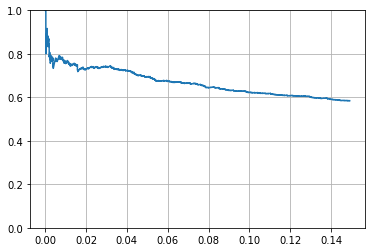

In [77]:
plt.plot(detections_df["Recall"],detections_df["Precision"])
plt.ylim([0,1])
plt.grid()

In [78]:
compute_ap(detections_df["Recall"].values, detections_df["Precision"].values)

0.10000139906982916

In [50]:
detections_df

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
633,000000087144.jpg,0.303114,0.273014,0.472200,0.503291,1.000000,0.004666,0.000513,0,1,0.405405,0,1,0.000000,0.000000
405,000000520707.jpg,0.480918,0.304915,0.601006,0.777006,1.000000,0.001196,0.003668,1,0,0.535946,1,1,0.500000,0.000091
2463,000000314709.jpg,0.316006,0.175049,0.461322,0.598326,1.000000,0.004079,0.001193,0,1,0.456013,1,2,0.333333,0.000091
1090,000000057597.jpg,0.790595,0.298465,0.909599,0.626643,1.000000,0.000895,0.006950,1,0,0.504502,2,2,0.500000,0.000182
3111,000000326174.jpg,0.574770,0.409321,0.657456,0.827097,1.000000,0.001641,0.001901,1,0,0.612122,3,2,0.600000,0.000273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,000000057760.jpg,0.876740,0.629706,0.893791,0.679303,0.501107,-1.000000,-1.000000,0,1,0.000000,1625,1507,0.518838,0.147674
255,000000273493.jpg,0.112126,0.351294,0.202902,0.728613,0.501045,0.001134,0.000245,0,1,0.485144,1625,1508,0.518672,0.147674
2084,000000472623.jpg,0.599563,0.315568,0.945599,0.768619,0.500931,0.002848,0.005574,1,0,0.674400,1626,1508,0.518826,0.147764
2309,000000188296.jpg,0.636864,0.332737,0.748294,0.749592,0.500728,0.001795,0.003656,1,0,0.755921,1627,1508,0.518979,0.147855


In [93]:
#os.chdir("/tf/home/sergio/")
#detections_df.to_csv("detections_df_best_result_2_anchors")

In [69]:
groud_truth_bboxes

array([], shape=(0, 4), dtype=float32)

In [70]:
groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)

In [71]:
groud_truth_bboxes

array([[0.63820314, 0.01355972, 0.9965938 , 0.98519903]], dtype=float32)

In [33]:
import cv2
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    #x_center, y_center, width, height = bbox#*416
    x_min,y_min,x_max,y_max=bbox
    #x_min = int(x_center-(width//2))
    #y_min = int(y_center-(height//2))
    #x_max = int(x_center+(width//2))
    #y_max = int(y_center+(height//2))
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    #class_name = class_idx_to_name[class_id]
    #((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    #cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    #cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(image,bboxes):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        img = visualize_bbox(img, bbox)
    plt.imshow(img)

In [34]:
predicted_boxes

array([[373.81348 ,  25.896667, 615.27    , 435.19962 ]], dtype=float32)

In [20]:
annotations_val_set[annotations_val_set.file_name == image]

,Unnamed: 0,file_name,xmin,ymin,xmax,ymax
9527,9527,000000170955.jpg,0.638203,0.01356,0.996594,0.985199


In [21]:
detections_df[detections_df.file_name == "000000397354.jpg"]
predicted_boxes = (detections_df[detections_df.file_name == "000000397354.jpg"].iloc[:,1:5]).values
print(predicted_boxes)

[[315.67272949 140.80905151 377.53302002 305.77975464]
 [111.07653809 186.75032043 191.20257568 334.90444946]
 [477.97073364 223.60594177 618.76519775 448.35531616]
 [202.08599854 153.03851318 297.49255371 300.46600342]]


In [22]:
img_raw = tf.image.decode_image(open("000000397354.jpg", 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = tf.image.resize(img, (416, 416))/255
    
visualize(resize(img.numpy()[0,:,:,:],(image_height,image_width)),predicted_boxes)

TypeError: Argument given by name ('color') and position (3)

In [ ]:
print(np.mean(detections_df["Precision"]))

## Evaluación del modelo original YOLO

In [31]:
anchors =[[10/416,14/416],[23/416,27/416],[37/416,58/416],[81/416,82/416],[135/416,169/416],[344/416,319/416]]
#anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)
model = TinyYOLOv3(80,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
model.build(batch_input_shape=(None,416,416,3))
model.load_weights_darknet(root_path+"/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights")
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_epoch_nadam_0dot0001_msle_exp_mse')

Pesos de la convolucion (432,)
CONV SHAPE (16, 3, 3, 3)
Pesos de la convolucion (4608,)
CONV SHAPE (32, 16, 3, 3)
Pesos de la convolucion (18432,)
CONV SHAPE (64, 32, 3, 3)
Pesos de la convolucion (73728,)
CONV SHAPE (128, 64, 3, 3)
Pesos de la convolucion (294912,)
CONV SHAPE (256, 128, 3, 3)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (4718592,)
CONV SHAPE (1024, 512, 3, 3)
Pesos de la convolucion (262144,)
CONV SHAPE (256, 1024, 1, 1)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (130560,)
CONV SHAPE (255, 512, 1, 1)
Pesos de la convolucion (32768,)
CONV SHAPE (128, 256, 1, 1)
Pesos de la convolucion (884736,)
CONV SHAPE (256, 384, 3, 3)
Pesos de la convolucion (65280,)
CONV SHAPE (255, 256, 1, 1)


8858734

In [32]:
inicio = time.time()
os.chdir(root_path+"/COCODataset/pedestrian_dataset_val")

detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","TP","FP"])
results_eval = []
obj_thresh = 0.3

for image in validation_images_names:
    #print(image)
    annotations_images_df = annotations_val_set[annotations_val_set.file_name==image]

    image_height = metadata_val_set.loc[image]["height"]
    image_width = metadata_val_set.loc[image]["width"]
    
    groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)
    groud_truth_bboxes[:,[0,2]] = groud_truth_bboxes[:,[0,2]]#*image_width
    groud_truth_bboxes[:,[1,3]] = groud_truth_bboxes[:,[1,3]]#*image_height
    
    img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = tf.image.resize(img, (416, 416))/255
    
    outputs = model(img);
    

    real_outputs = outputs[2].numpy()[0,0:outputs[3][0].numpy()]
    person_index = np.where(real_outputs ==0)
    #print(person_index)
    #person_outputs 
    predicted_boxes = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:][person_index,:][0,:,:]
    scores = outputs[1].numpy()[0,0:outputs[3][0].numpy()][person_index]
        
    #print(predicted_boxes.shape)
    #print(scores.shape)
    
    predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]#*image_width
    predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]#*image_height

    for box,score in zip(predicted_boxes,scores):

        iou_resulted,iou = get_iou_matrix_tf(groud_truth_bboxes, box[tf.newaxis,:])
        
        if np.sum(iou_resulted) >= 1:
            tp = 1
            fp = 0
            which_gt = np.argmax(iou)
            iou_value = np.max(iou)
            #print(iou_value)
            coord_gt = groud_truth_bboxes[which_gt,:]
            
            xy_error,wh_error = errors(box,coord_gt)
            
            groud_truth_bboxes=np.delete(groud_truth_bboxes,which_gt,axis=0)
        #NO hay algún ground truth con el que tenga mas de 0.5 de IoU    
        elif np.sum(iou_resulted) == 0:
            fp = 1
            tp = 0
            
            
            #EL objeto predicho de plano no machea con ninǵún ground truth
            if iou.shape[0]>0  and np.sum(iou)==0:
                iou_value=0
                xy_error=-1
                wh_error=-1    
            #EL objeto predicho hizo match con algún ground truth pero no lo suficiente paara ser un TP    
            elif iou.shape[0]>0  and np.sum(iou)>0:
                
                iou_value = np.max(iou)
                which_gt = np.argmax(iou)
                coord_gt = groud_truth_bboxes[which_gt,:]
                xy_error,wh_error = errors(box,coord_gt)                
                
            # La red detecto un objecto donde ya no hay groudn truth 
            elif iou.shape[0]==0:
                
                iou_value=0
                xy_error=-2
                wh_error=-2     

        predicted_dict = {"file_name":[image],"xmin":[box[0]],"ymin":[box[1]],"xmax":[box[2]],"ymax":[box[3]],"score":[score],
                          "xy_error":[xy_error],"wh_error":[wh_error],"iou":[iou_value],"TP":[tp],"FP":[fp]}
        aux = pd.DataFrame(predicted_dict)
        detections_df = pd.concat((detections_df,aux),ignore_index=True)
        #print(aux)        
        
        #print(groud_truth_bboxes)
        #print(iou)
    '''
    x_min,y_min,x_max,y_max =np.split(predicted_boxes,4,axis=1)
    x_min,x_max = x_min*image_width,x_max*image_width
    y_min,y_max = y_min*image_height,y_max*image_height
    
    width = x_max-x_min
    height = y_max-y_min
    x_global =x_min + tf.math.divide(x_max - x_min,2)
    y_global =y_min + tf.math.divide(y_max - y_min,2)    
    '''
detections_df = detections_df.sort_values(by="score",ascending=False)
cum_tp = np.cumsum(detections_df["TP"].values)
cum_fp = np.cumsum(detections_df["FP"].values)
detections_df.insert(detections_df.shape[1],"cum TP",cum_tp)
detections_df.insert(detections_df.shape[1],"cum FP",cum_fp)
detections_df["Precision"]= detections_df.loc[:,"cum TP"]/(detections_df.loc[:,"cum TP"] + detections_df.loc[:,"cum FP"])
detections_df["Recall"]= detections_df.loc[:,"cum TP"]/11004

fin = time.time()
print(fin-inicio)

65.51918458938599


In [33]:
detections_df

,file_name,xmin,ymin,xmax,ymax,score,TP,FP,xy_error,wh_error,iou,cum TP,cum FP,Precision,Recall
2301,000000038210.jpg,0.150684,0.427492,0.500176,0.880573,0.999887,1,0,0.000590,0.001437,0.828073,1,0,1,9.0876e-05
1513,000000427160.jpg,0.000000,0.415472,0.442092,1.000000,0.998726,1,0,0.000593,0.002429,0.846520,2,0,1,0.000181752
2489,000000213171.jpg,0.360051,0.287187,0.665166,0.884630,0.998278,1,0,0.000249,0.000128,0.895790,3,0,1,0.000272628
2762,000000133567.jpg,0.036695,0.486220,0.204128,1.000000,0.997423,1,0,0.000227,0.000776,0.856954,4,0,1,0.000363504
1737,000000188465.jpg,0.361481,0.542928,0.518214,0.826184,0.996834,1,0,0.000022,0.000430,0.889355,5,0,1,0.00045438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,000000092939.jpg,0.467950,0.178509,0.847671,0.787454,0.500404,1,0,0.000779,0.015901,0.706358,1743,1527,0.533028,0.158397
1632,000000451144.jpg,0.581005,0.398370,0.704933,0.796472,0.500340,1,0,0.000041,0.000223,0.875573,1744,1527,0.53317,0.158488
128,000000392722.jpg,0.500435,0.650183,0.535096,0.707777,0.500196,0,1,0.000061,0.008848,0.339056,1744,1528,0.533007,0.158488
742,000000233771.jpg,0.765753,0.702676,0.832660,0.944235,0.500133,0,1,0.022561,0.015457,0.058645,1744,1529,0.532844,0.158488


In [34]:
#os.chdir("/tf/home/sergio/")
#detections_df.to_csv("detections_df_original")

In [35]:
detections_df[detections_df.iou != 0].loc[:,["score","xy_error","wh_error","iou"]].describe()

,score,xy_error,wh_error,iou
count,3095.000000,3.095000e+03,3.095000e+03,3095.000000
mean,0.731165,3.493789e-03,2.884628e-02,0.553295
std,0.147491,1.971305e-02,1.384266e-01,0.278347
min,0.500079,8.790930e-08,7.891799e-07,0.001144
25%,0.599684,6.722751e-05,1.284006e-03,0.282306
50%,0.718884,2.116786e-04,4.574302e-03,0.655873
75%,0.862270,7.591554e-04,1.230912e-02,0.809418
max,0.999887,3.399086e-01,1.644850e+00,0.969979


In [36]:
detections_df[detections_df.iou == 0]

,file_name,xmin,ymin,xmax,ymax,score,TP,FP,xy_error,wh_error,iou,cum TP,cum FP,Precision,Recall
1738,000000188465.jpg,0.407143,0.591740,0.478071,0.778925,0.993321,0,1,-1.0,-1.0,0.0,19,1,0.95,0.00172664
2124,000000414170.jpg,0.581575,0.471272,0.668803,0.697526,0.990044,0,1,-1.0,-1.0,0.0,28,3,0.903226,0.00254453
2295,000000516318.jpg,0.621593,0.505404,0.735774,0.668789,0.985258,0,1,-2.0,-2.0,0.0,51,5,0.910714,0.00463468
1657,000000230819.jpg,0.331303,0.383653,0.407461,0.607156,0.976861,0,1,-2.0,-2.0,0.0,98,18,0.844828,0.00890585
2126,000000414170.jpg,0.352634,0.461123,0.423347,0.599882,0.970667,0,1,-1.0,-1.0,0.0,138,27,0.836364,0.0125409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,000000071877.jpg,0.329697,0.058859,0.805247,0.441032,0.504287,0,1,-2.0,-2.0,0.0,1729,1506,0.534467,0.157125
1540,000000378244.jpg,0.384560,0.452061,0.509264,0.581538,0.503933,0,1,-2.0,-2.0,0.0,1729,1509,0.533972,0.157125
1011,000000015956.jpg,0.701783,0.398164,0.736017,0.485610,0.502924,0,1,-1.0,-1.0,0.0,1733,1511,0.534217,0.157488
1101,000000117197.jpg,0.605410,0.249539,0.820185,0.746029,0.502919,0,1,-2.0,-2.0,0.0,1733,1512,0.534052,0.157488


In [37]:
final_p = detections_df.Precision.iloc[-1]
final_r = detections_df.Recall.iloc[-1]
f1_score = (2*final_p*final_r)/(final_p+final_r)

In [38]:
f1_score

0.24429191763552321

In [39]:
detections_df[detections_df.iou != 0][detections_df.FP==1].loc[:,["score","xy_error","wh_error","iou"]].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,score,xy_error,wh_error,iou
count,1351.000000,1.351000e+03,1351.000000,1351.000000
mean,0.689019,6.781075e-03,0.059832,0.258667
std,0.133750,2.942135e-02,0.205173,0.106216
min,0.500079,8.790930e-08,0.000039,0.001144
25%,0.576978,4.096714e-05,0.005470,0.206485
50%,0.665204,1.253977e-04,0.011268,0.265487
75%,0.790697,4.945673e-04,0.020823,0.325957
max,0.993061,3.399086e-01,1.644850,0.498351


In [40]:
print("Objetos detectados que no correspondieron a algún GT",len(detections_df[detections_df.xy_error == -1]))
print("Objetos detectados donde ya no habían GT",len(detections_df[detections_df.xy_error == -2]))
print("Total:",len(detections_df[detections_df.xy_error == -1])+len(detections_df[detections_df.xy_error == -2]) )

Objetos detectados que no correspondieron a algún GT 120
Objetos detectados donde ya no habían GT 59
Total: 179


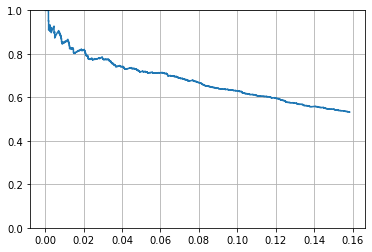

In [41]:
plt.plot(detections_df["Recall"],detections_df["Precision"])
plt.ylim([0,1])
plt.grid()

In [42]:
compute_ap(detections_df["Recall"].values, detections_df["Precision"].values)

0.10801317600914442